Sampling: [a_bar, a_offset, b_offset, sigma_a, sigma_b, theta]


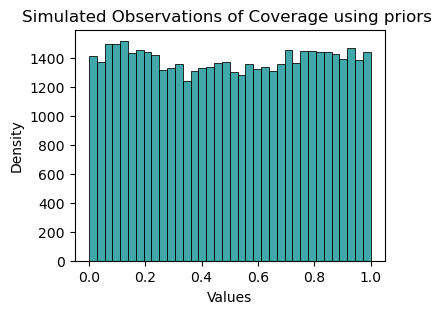

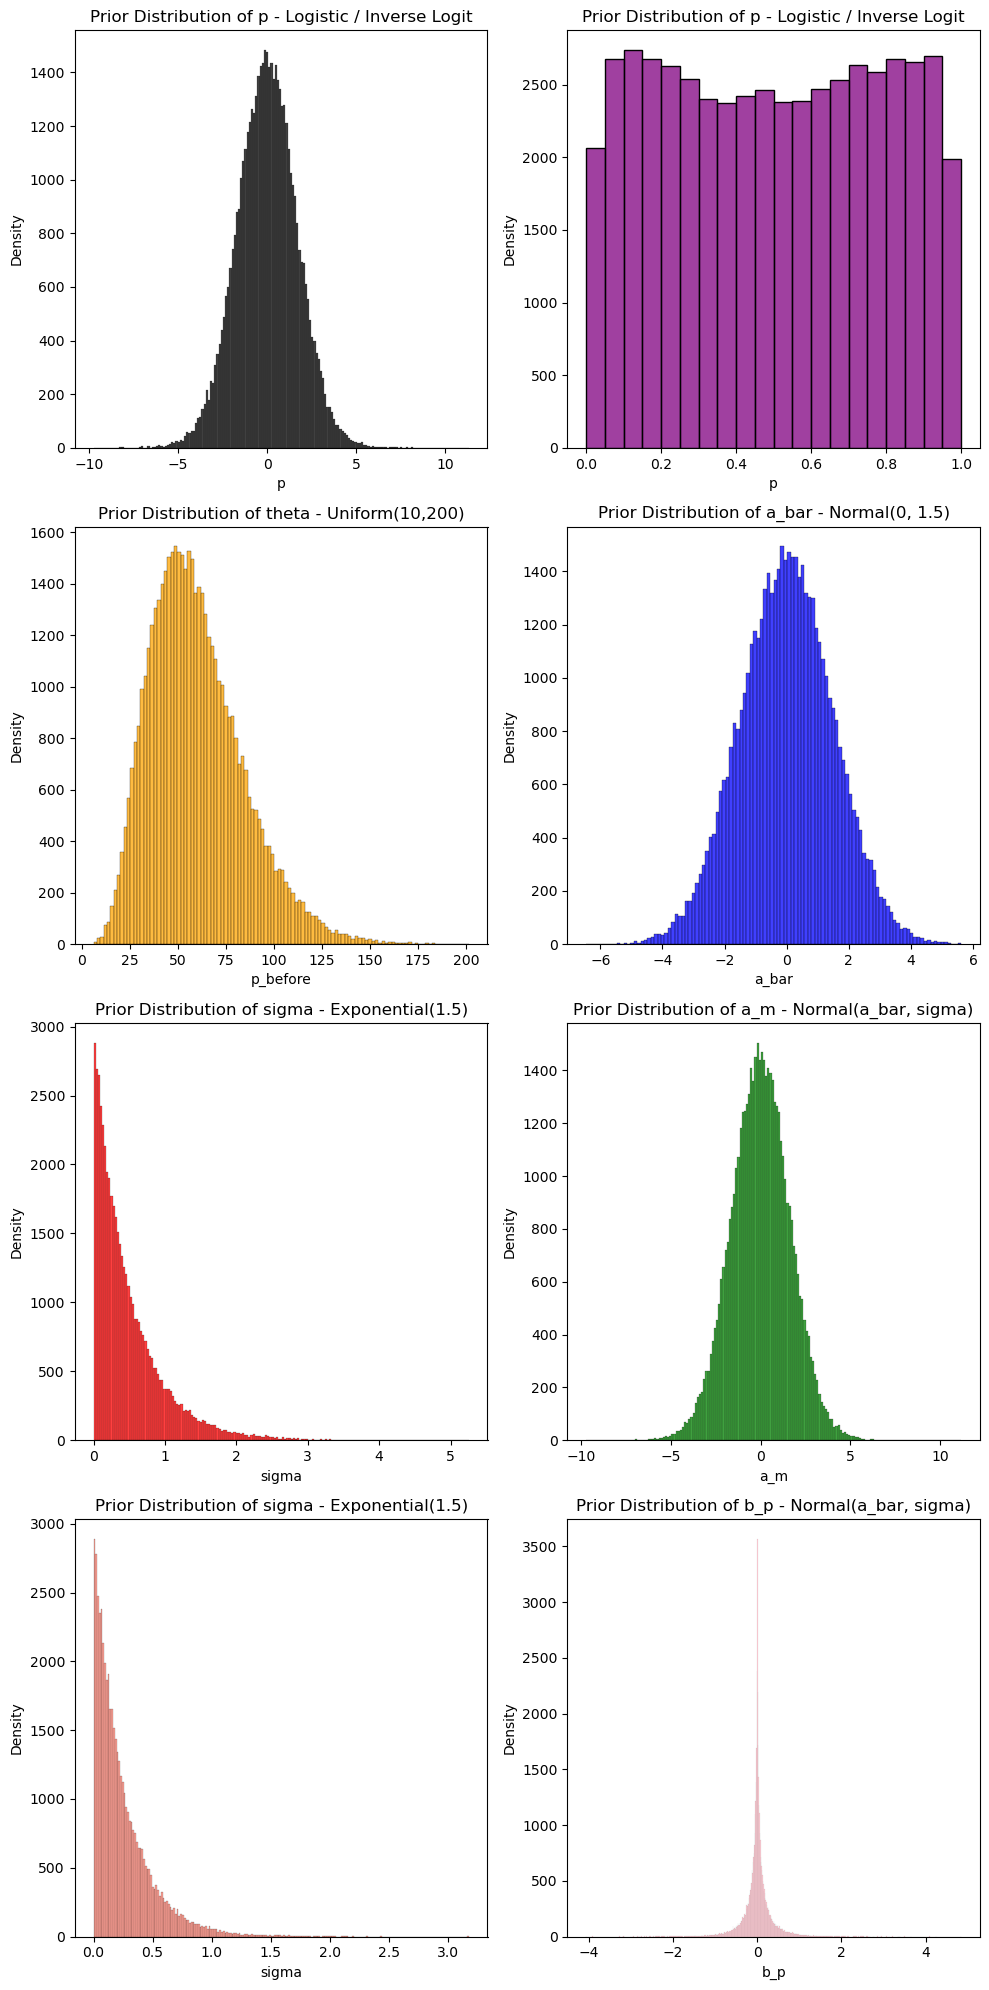

In [23]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def calc_prior_dist(s_a, s_b, a_bar_mu, a_bar_sigma):
    with pm.Model():
        # Global Intercept and standard deviation for Modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Modules, Parameters and Interactions
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        
        # Non-centered parameterizations for module, parameter and interaction effect.
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)
        
        pm.Deterministic('p_before', (a_m + b_p))

        # Link function (logit), unbounded to (0,1) probability
        pm.Deterministic('p', pm.math.sigmoid(a_m + b_p))
        
        # Beta distribution likelihood 
        pm.Gamma('theta', alpha=6, beta= 0.1) # Disperion parameter

        # Sample Priors
        idata = pm.sample_prior_predictive(samples=50000)


    # Fetch and flatten priors
    prior_p = idata.prior['p'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()

    # Sample one data point from each combination
    simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


    #Predicated observations
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Simulated Observations of Coverage using priors ', 'Values',
                                        'darkcyan', bin_range=(0, 1.0))
    observation_plot.plot()


    plots = [
        HistogramPlot(idata.prior['p_before'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'black'),
        HistogramPlot(idata.prior['p'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'purple', bin_range=(0, 1), bins=20),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior Distribution of theta - Uniform(10,200)', 'p_before', 'orange'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior Distribution of a_bar - Normal(0, 1.5)', 'a_bar', 'blue'),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'red'),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior Distribution of a_m - Normal(a_bar, sigma)', 'a_m', 'green'),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'salmon'),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'b_p', 'pink'),
    ]

    plot_histograms(plots, 4, 2, figsize=(10,20))


s_a = FloatSlider(value=2, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
s_b = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
#s_g = FloatSlider(value=5, min=0.5, max=6, step=0.1, description='Sigma_gamma (sigma_g):')
a_bar_mu = FloatSlider(value=0, min=-2, max=2, step=0.1, description='alpha bar mu (a_bar_mu):')
a_bar_sigma = FloatSlider(value=1.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')
#max_theta = FloatSlider(value=200, min=20, max=200, step=0.1, description='max bar sigma (a_bar_sigma):')



# Interactive sliders
#interact(calc_prior_dist, s_a=s_a, s_b=s_b, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma)
calc_prior_dist(2, 4, 0, 1.5)

In [19]:
import pymc as pm
import pandas as pd
from utils.design_matrix_creator import get_design_matricies

data = pd.read_csv("../multi_parameter/combined_data/statistics.csv")

observation_matrix, module_matrix, parameter_matrix, _ = get_design_matricies(data, 'Coverage')


Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


In [20]:
with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard Deviations for modules, marameters and nteractions
    sigma_a = pm.Exponential('sigma_a', 2.0)
    sigma_b = pm.Exponential('sigma_b', 4.0)

    # Non-centered parameterizations for module, parameter and interaction effect.
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=66)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)
    
    # Activate the correct dummy variables
    logit_a = pm.math.dot(module_matrix, a_m)
    logit_b = pm.math.dot(parameter_matrix, b_p)

    # Link function (logit), unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.sigmoid(logit_a + logit_b))
    
    # Beta distribution likelihood 
    theta = pm.Gamma('theta', alpha=6, beta= 0.1) # Disperion parameter
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=observation_matrix['Coverage'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4,return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Model building complete.")

Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_a, sigma_b, a_offset, b_offset, theta]


Output()

Sampling 4 chains for 5 tune and 5 draw iterations (20 + 20 draws total) took 3 seconds.
The number of samples is too small to check convergence reliably.


Output()

Model building complete.


### Save the results

In [ ]:
import arviz as az

az.to_netcdf(trace, "final_coverage_multi_parameter.nc")

# Show the results


In [14]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp, logit_to_probability
import pandas as pd
pd.set_option('display.max_rows', 500)  # Increase number of rows

# Example usage
trace = az.from_netcdf("../final_coverage_multi_parameter.nc")
variable_list = ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p']
transformations = {
    #'a_m': log_to_exp,
    #'a_bar': logit_to_probability,
    #'sigma_a': logit_to_probability
    #'b_p': log_to_exp
}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
table = az.summary(idata, variable_list, hdi_prob=0.89)
table

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_m[0],-0.021,0.143,-0.217,0.164,0.033,0.023,19.0,19.0,3.84
a_m[1],0.034,0.236,-0.185,0.416,0.054,0.039,19.0,16.0,2.21
a_m[2],0.247,0.105,0.113,0.359,0.024,0.017,19.0,19.0,1.96
a_m[3],0.162,0.193,-0.100,0.362,0.044,0.032,19.0,19.0,3.50
a_m[4],-0.083,0.147,-0.218,0.152,0.034,0.024,19.0,19.0,2.08
a_m[5],0.031,0.143,-0.107,0.225,0.033,0.023,19.0,16.0,2.21
a_m[6],0.143,0.156,-0.094,0.340,0.035,0.025,19.0,19.0,2.89
a_m[7],0.060,0.151,-0.040,0.327,0.034,0.025,19.0,19.0,2.16
a_m[8],-0.094,0.224,-0.378,0.220,0.051,0.037,19.0,19.0,3.96
a_m[9],-0.006,0.217,-0.223,0.328,0.049,0.035,19.0,19.0,2.30


array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>]],
      dtype=object)

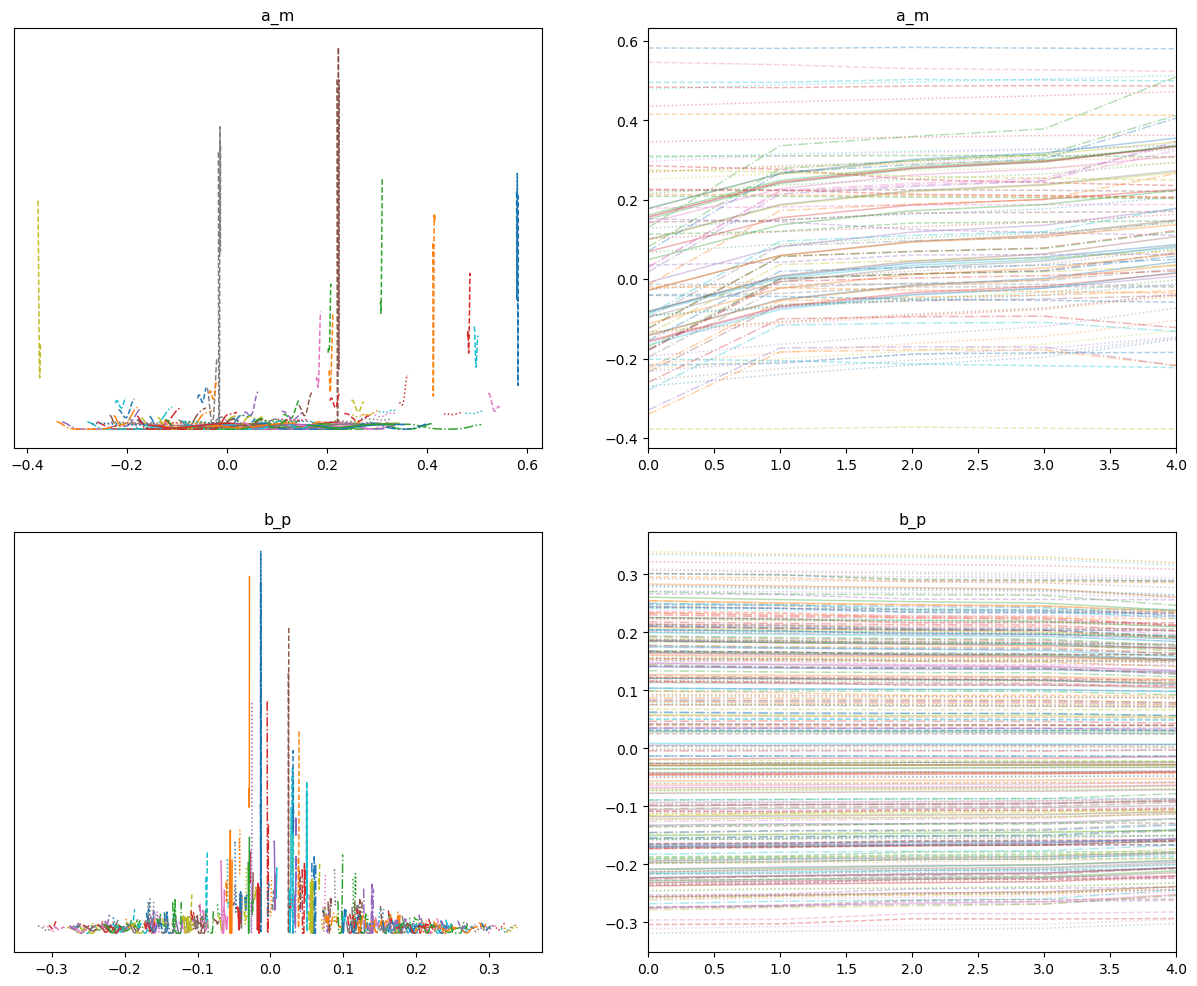

In [16]:
az.plot_trace(idata, var_names=['a_m', 'b_p' ], figsize=(15, 12))

In [7]:
import arviz as az

az.to_netcdf(trace, "model_3_trace_1000.nc")

'model_3_trace_1000.nc'

In [8]:
az.loo(az.from_netcdf("model_3_trace_1000.nc"))

Computed from 4000 posterior samples and 9360 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 13388.16   235.42
p_loo      130.07        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9360  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Sampling: [a_bar, a_offset, b_offset, sigma_a, sigma_b, theta]


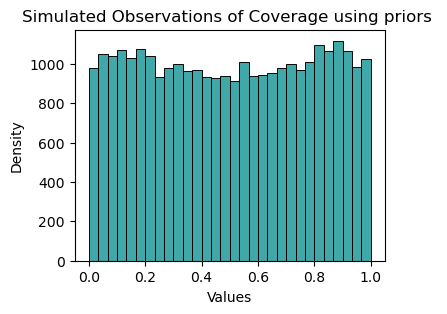

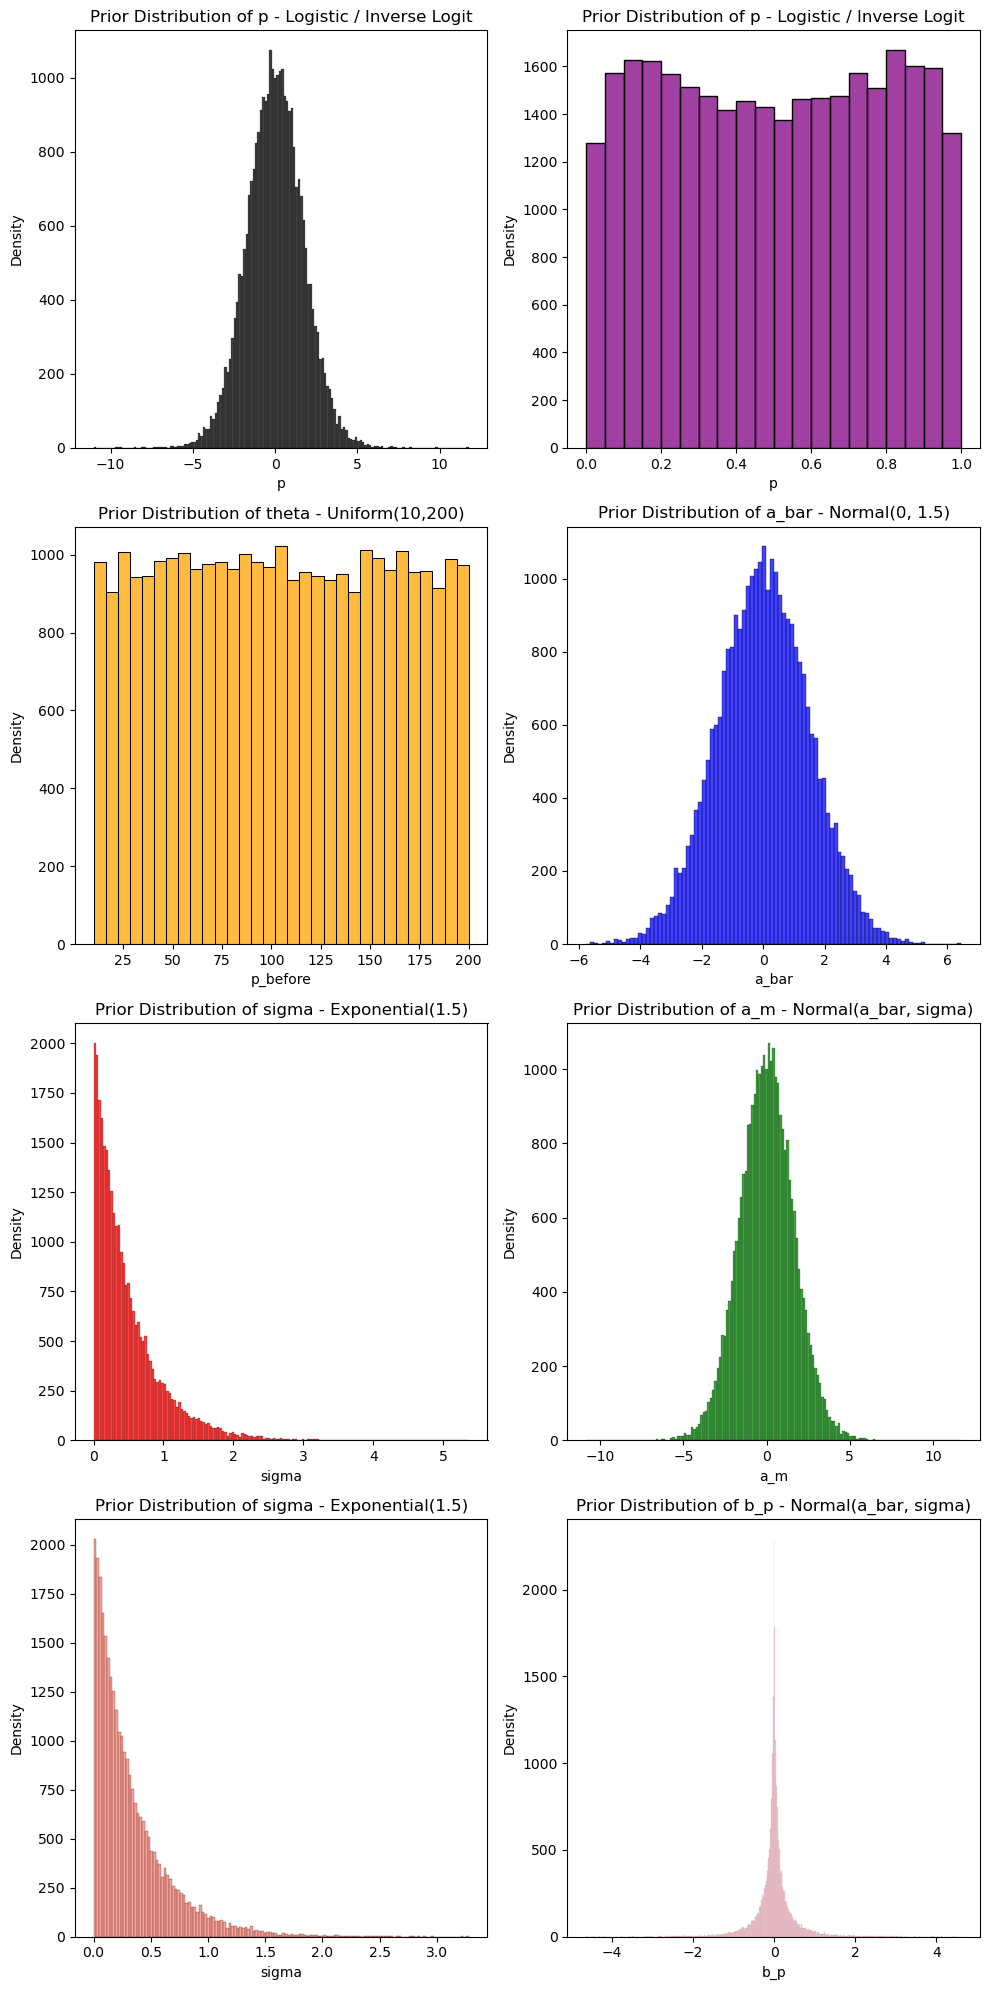

In [12]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def calc_prior_dist(s_a, s_b, a_bar_mu, a_bar_sigma, max_theta):
    with pm.Model():
        # Global Intercept and standard deviation for Modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Modules, Parameters and Interactions
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)

        # Non-centered parameterizations for module, parameter and interaction effect.
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        
        pm.Deterministic('p_before', (a_m + b_p))

        # Link function (logit), unbounded to (0,1) probability
        pm.Deterministic('p', pm.math.sigmoid(a_m + b_p))
        
        # Beta distribution likelihood 
        pm.Uniform('theta', 10, max_theta) # Disperion parameter

        # Sample Priors
        idata = pm.sample_prior_predictive(samples=30000)


    # Fetch and flatten priors
    prior_p = idata.prior['p'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()


    # Sample one data point from each combination
    simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


    #Predicated observations
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Simulated Observations of Coverage using priors ', 'Values',
                                        'darkcyan', bin_range=(0, 1.0))
    observation_plot.plot()


    plots = [
        HistogramPlot(idata.prior['p_before'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'black'),
        HistogramPlot(idata.prior['p'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'purple', bin_range=(0, 1), bins=20),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior Distribution of theta - Uniform(10,200)', 'p_before', 'orange'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior Distribution of a_bar - Normal(0, 1.5)', 'a_bar', 'blue'),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'red'),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior Distribution of a_m - Normal(a_bar, sigma)', 'a_m', 'green'),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'salmon'),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'b_p', 'pink'),
    ]

    plot_histograms(plots, 4, 2, figsize=(10,20))


s_a = FloatSlider(value=2, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
s_b = FloatSlider(value=3, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
a_bar_mu = FloatSlider(value=0, min=-2, max=2, step=0.1, description='alpha bar mu (a_bar_mu):')
a_bar_sigma = FloatSlider(value=1.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')
max_theta = FloatSlider(value=200, min=20, max=200, step=0.1, description='max bar sigma (a_bar_sigma):')



# Interactive sliders
#interact(calc_prior_dist, s_a=s_a, s_b=s_b, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma, max_theta=max_theta)
calc_prior_dist(2, 3, 0, 1.5, 200)